In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/home/dnash/comet_data/'

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

## Load preprocessed 250Z, IVT and MSLP data

In [3]:
## load difference composites
fname = path_to_data + 'preprocessed/ERA5_ivt_250z_mslp_daily_diff_composite.nc'
ds_diff_final = xr.open_dataset(fname)
# convert geopotential to geopotential height (m)
ds_diff_final = ds_diff_final.assign(z=lambda ds_diff_final: ds_diff_final['z']/(9.80665))

## load pval composites
fname = path_to_data + 'preprocessed/ERA5_ivt_250z_mslp_daily_pval_composite.nc'
ds_pval_final = xr.open_dataset(fname)

In [4]:
ds_diff_final

<xarray.Dataset>
Dimensions:    (lon: 281, lat: 245, lag: 5, community: 6)
Coordinates:
  * lon        (lon) float32 -180.0 -179.8 -179.5 ... -110.5 -110.2 -110.0
  * lat        (lat) float32 80.0 79.75 79.5 79.25 ... 19.75 19.5 19.25 19.0
  * lag        (lag) int64 -4 -3 -2 -1 0
  * community  (community) object 'Hoonah' 'Skagway' ... 'Craig' 'Kasaan'
    level      int32 ...
Data variables:
    IVTv       (community, lag, lat, lon) float32 ...
    IVTu       (community, lag, lat, lon) float32 ...
    IVT        (community, lag, lat, lon) float32 ...
    msl        (community, lag, lat, lon) float32 ...
    z          (community, lag, lat, lon) float32 17.56 17.57 ... -13.59 -13.57

In [5]:
## load special composites
fname = path_to_data + 'preprocessed/ERA5/ERA5_ivt_250z_mslp_daily_composite_special.nc'
ds_special = xr.open_dataset(fname)
ds_special

len_special = [56, 1266, 566]

In [6]:
## read clim data
varname_lst = ['huv', 'ivt', 'mslp']
ds_lst = []
for i, varname in enumerate(varname_lst):
    fname = path_to_data + 'preprocessed/ERA5/ERA5_{0}_clim.nc'.format(varname)
    ds = xr.open_dataset(fname)
    del ds.attrs['history']
    ds_lst.append(ds)
ds_clim = xr.combine_by_coords(ds_lst)
ds_clim = ds_clim.mean('season')

## Plot IVT and 250Z Composites

In [7]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds_clim.lat.values
lons = ds_clim.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round()+1,lats.max().round()+10,10)

# ext1 = [-141., -130., 54., 61.] # extent of SEAK
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# locations of communities
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
community_lst = lbl1
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
sig_level = 0.05 # significance level to plot filled contours

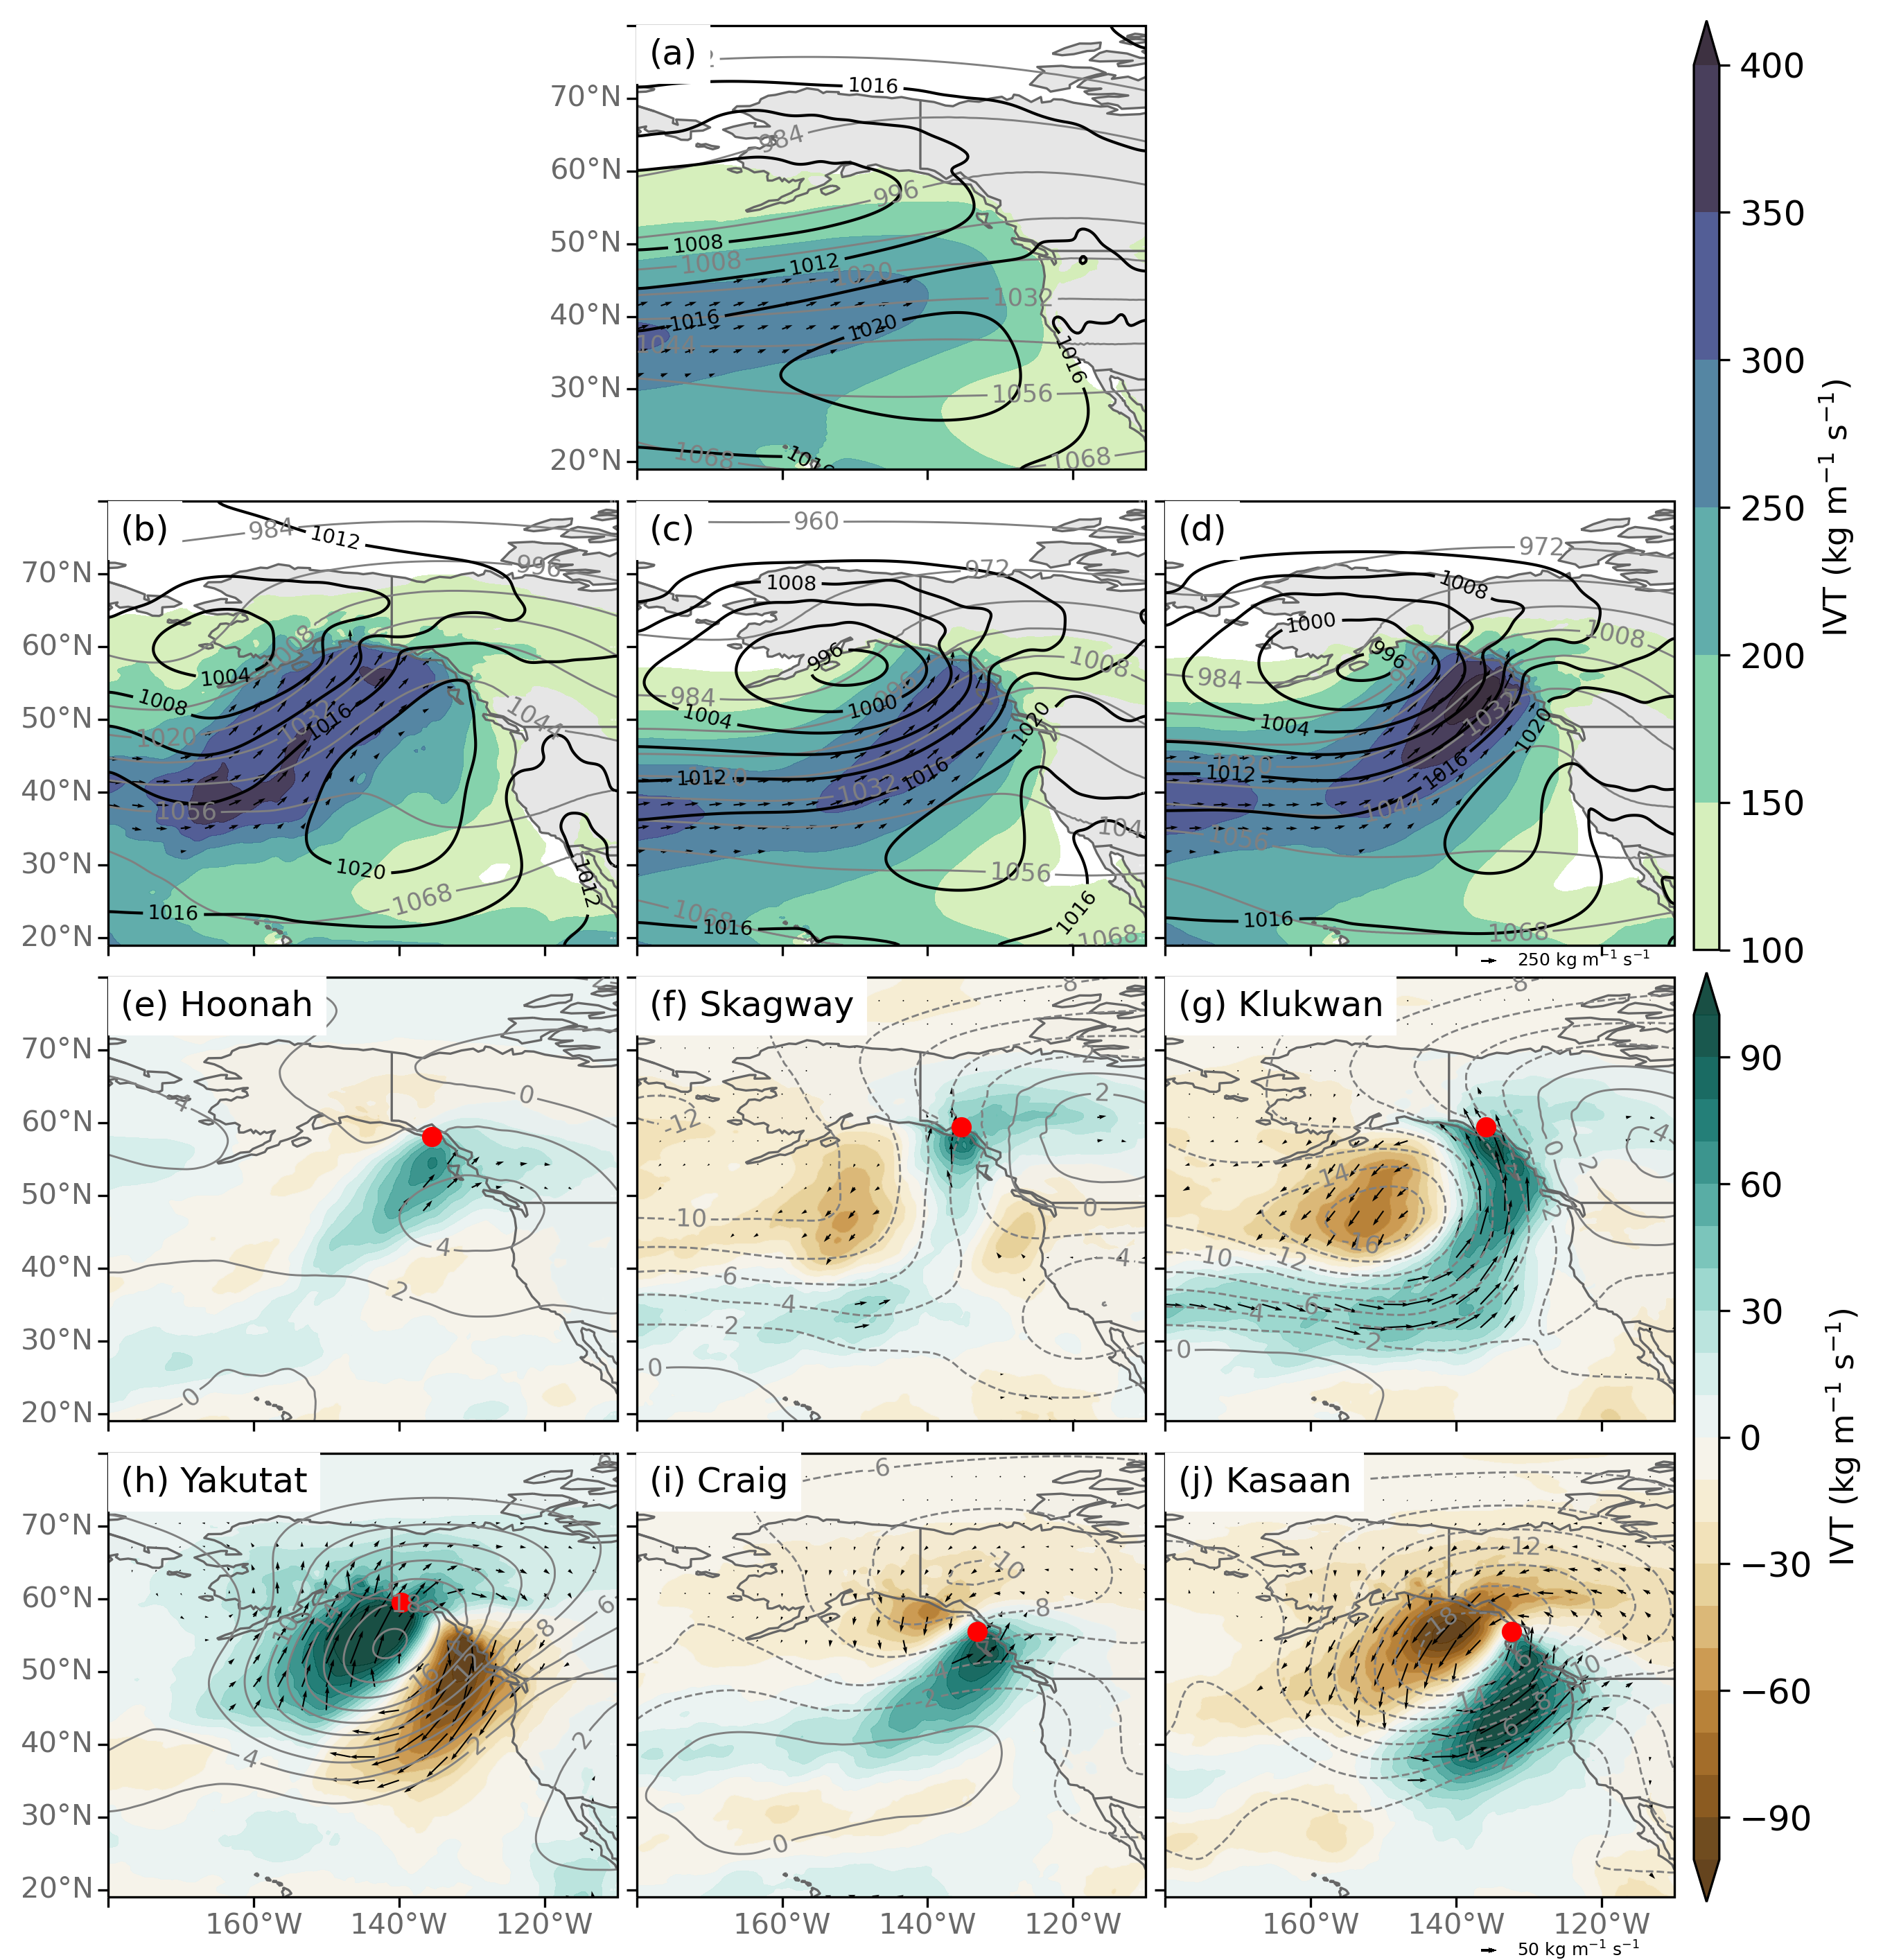

In [8]:
# Create figure
fig = plt.figure(figsize=(10, 11.75))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_IVT-250Z_composite_final'
fmt = 'png'

nrows = 4
ncols = 4

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1], width_ratios = [1, 1, 1, 0.05], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################

ax = fig.add_subplot(gs[0, 1], projection=mapcrs)
    
ds = ds_clim
ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=False)

# Contour Filled
lats = ds.lat.values
lons = ds.lon.values
ivt = ds.IVT.values
cflevs = np.arange(100, 450, 50) # levels for IVT
cmap = cmo.deep # cmap for IVT
cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                 levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

# Wind barbs / vectors 
uvec = ds.IVTu.values
vvec = ds.IVTv.values
uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
          color='k', regrid_shape=20,
          angles='xy', scale_units='xy', scale=125, units='xy')

# ax.set_title(community_lst[k], loc='left', fontsize=10)
titlestring = '({0})'.format(letter_lst[0])
ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

# Contour Lines
hgts = ds.z.values/(100) # convert to dekameters # 250-hPa Heights
clevs = np.arange(696, 1280, 12)
cs = ax.contour(lons, lats, hgts, transform=datacrs,
                levels=clevs, colors='grey', linewidths=0.7)
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Plot MSLP
clevs_slp = np.arange(800., 1120., 4)
slp_smooth = gaussian_filter(ds.msl.values/100., sigma=4)
cs2 = ax.contour(lons, lats, slp_smooth, transform=datacrs,
                 levels=clevs_slp, colors='k',
                 linewidths=1., linestyles='solid')
plt.clabel(cs2, **kw_clabels)

##########################
### SPECIAL COMPOSITES ###
##########################
special_lst = ['left', 'middle', 'right']
left_lat_lst = [True, False, False]
colidx_lst = [0, 1, 2]
for k, colidx in enumerate(colidx_lst):
    ax = fig.add_subplot(gs[1, colidx], projection=mapcrs)
    
    ds = ds_special.sel(special=special_lst[k], lag=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=left_lat_lst[k], right_lats=False, bottom_lons=False)

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.IVTu.values
    vvec = ds.IVTv.values
    uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    titlestring = '({0})'.format(letter_lst[k+1])
    ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    hgts = ds.z.values/(100) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(696, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)
    
    # Plot MSLP
    clevs_slp = np.arange(800., 1120., 4)
    slp_smooth = gaussian_filter(ds.msl.values/100., sigma=4)
    cs2 = ax.contour(lons, lats, slp_smooth, transform=datacrs,
                     levels=clevs_slp, colors='k',
                     linewidths=1., linestyles='solid')
    plt.clabel(cs2, **kw_clabels)
    
# quiver key
qk = ax.quiverkey(Q, 0.65, -0.035, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})


# Add color bar
cbax = plt.subplot(gs[0:2,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)


############################
### COMMUNITY COMPOSITES ###
############################
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
rowidx_lst = [2, 2, 2, 3, 3, 3]
colidx_lst = [0, 1, 2, 0, 1, 2]
for k, (rowidx, colidx) in enumerate(zip(rowidx_lst, colidx_lst)):
    ax = fig.add_subplot(gs[rowidx, colidx], projection=mapcrs)
    
    ds = ds_diff_final.sel(community=community_lst[k], lag=0)
    pval = ds_pval_final.sel(community=community_lst[k], lag=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=left_lat_lst[k], right_lats=False, bottom_lons=bottom_lon_lst[k])

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    # ivt_mask = ds.IVT.where((pval.IVT <= sig_level)).values
    cflevs = np.arange(-100, 110, 10) # levels for IVT
    cmap = 'BrBG' # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')
    
    # Wind barbs / vectors 
    uvec = ds.IVTu.values
    uvec_mask = ds.IVTu.where((pval.IVT <= sig_level) & (pval.z <= sig_level)).values
    vvec = ds.IVTv.values
    vvec_mask = ds.IVTv.where((pval.IVT <= sig_level) & (pval.z <= sig_level)).values

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=25, units='xy')


    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    titlestring = '({0}) {1}'.format(letter_lst[k+4], community_lst[k])
    ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    hgts = ds.z.values/(10) # convert to dekameters # 250-hPa Heights
    # hgts_mask = ds.z.where((pval.z <= sig_level)).values/(10.) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(-20,22,2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ro', markersize=6, transform=datacrs)
    
# quiver key
qk = ax.quiverkey(Q, 0.65, -0.12, 50, '50 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})

# Add color bar
cbax = plt.subplot(gs[2:,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

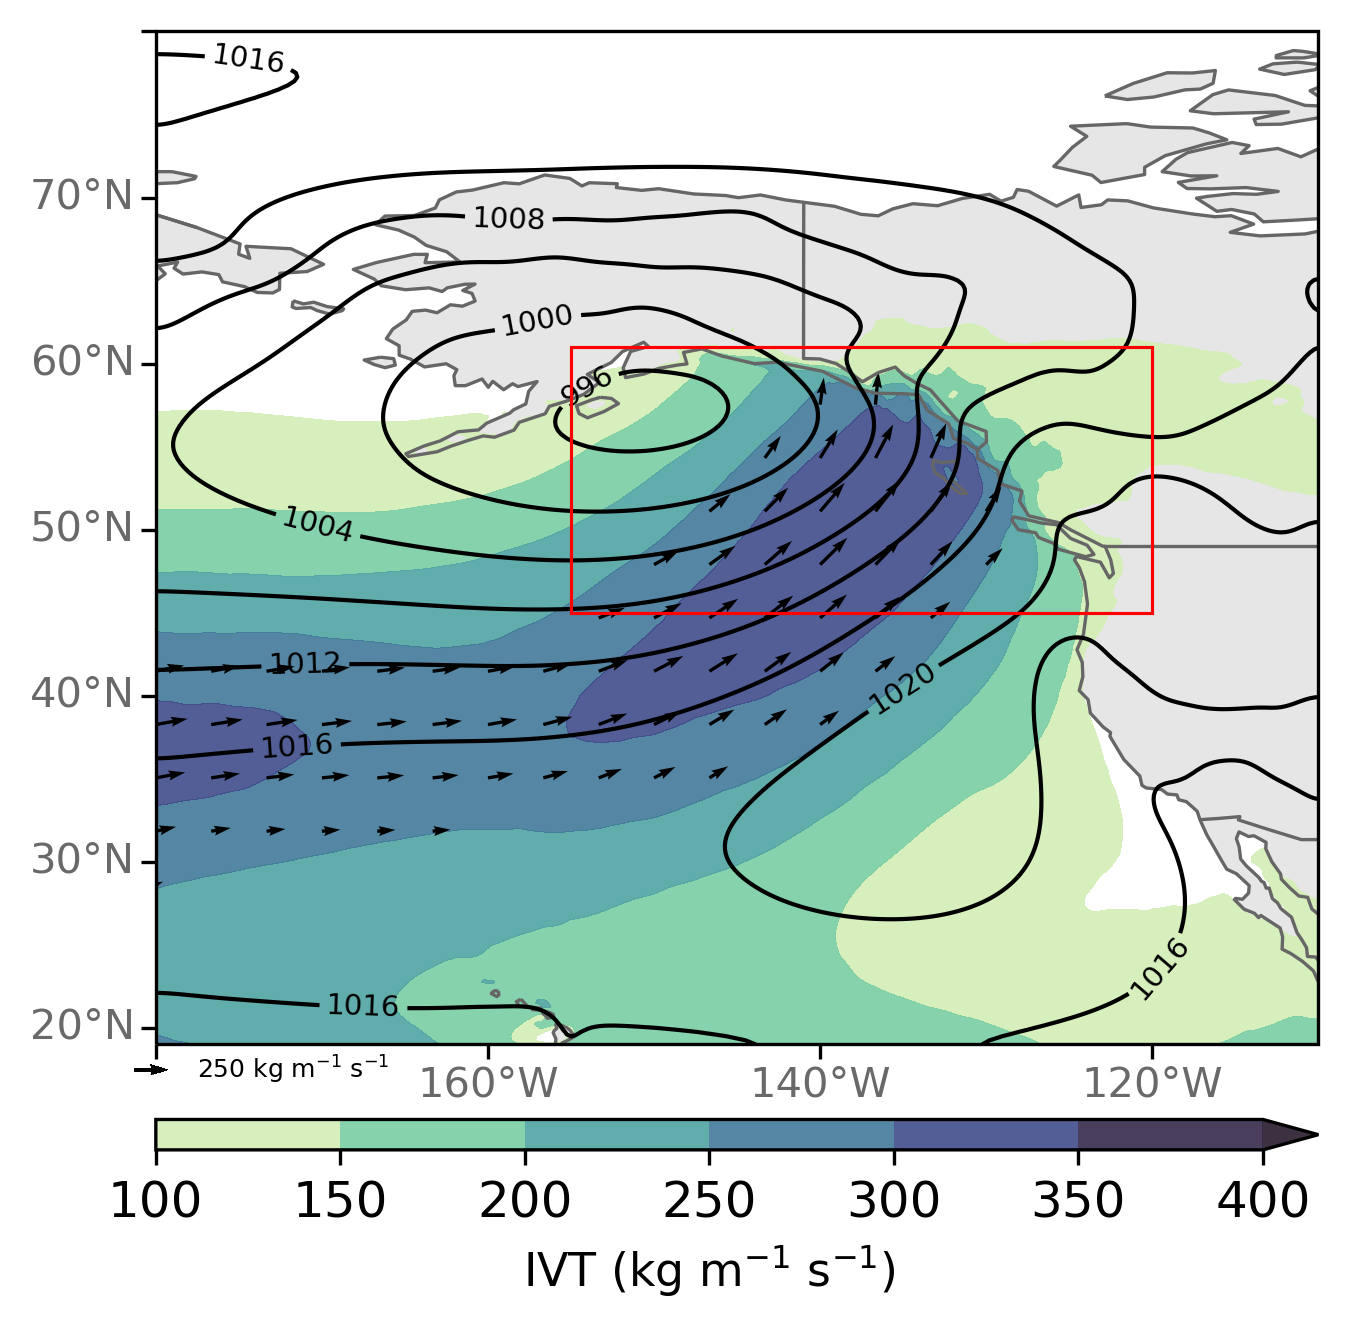

In [11]:
# Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_IVT-250Z_composite_poster'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

############################
### EXTREME AR COMPOSITE ###
############################

for k, ax in enumerate(axgr):
    
    ds = ds_special.sel(special=special_lst[1], lag=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.IVTu.values
    vvec = ds.IVTv.values
    uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # # Contour Lines
    # hgts = ds.z.values/(100) # convert to dekameters # 250-hPa Heights
    # clevs = np.arange(696, 1280, 12)
    # cs = ax.contour(lons, lats, hgts, transform=datacrs,
    #                 levels=clevs, colors='grey', linewidths=0.7)
    # plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

    # Plot MSLP
    clevs_slp = np.arange(800., 1120., 4)
    slp_smooth = gaussian_filter(ds.msl.values/100., sigma=4)
    cs2 = ax.contour(lons, lats, slp_smooth, transform=datacrs,
                     levels=clevs_slp, colors='k',
                     linewidths=1., linestyles='solid')
    plt.clabel(cs2, **kw_clabels)

    # quiver key
    qk = ax.quiverkey(Q, 0.01, -0.025, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 6.0})
    ext3 = [-141., -130., 54.5, 60.]
    ext3 = [-155., -120., 45., 61.]
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

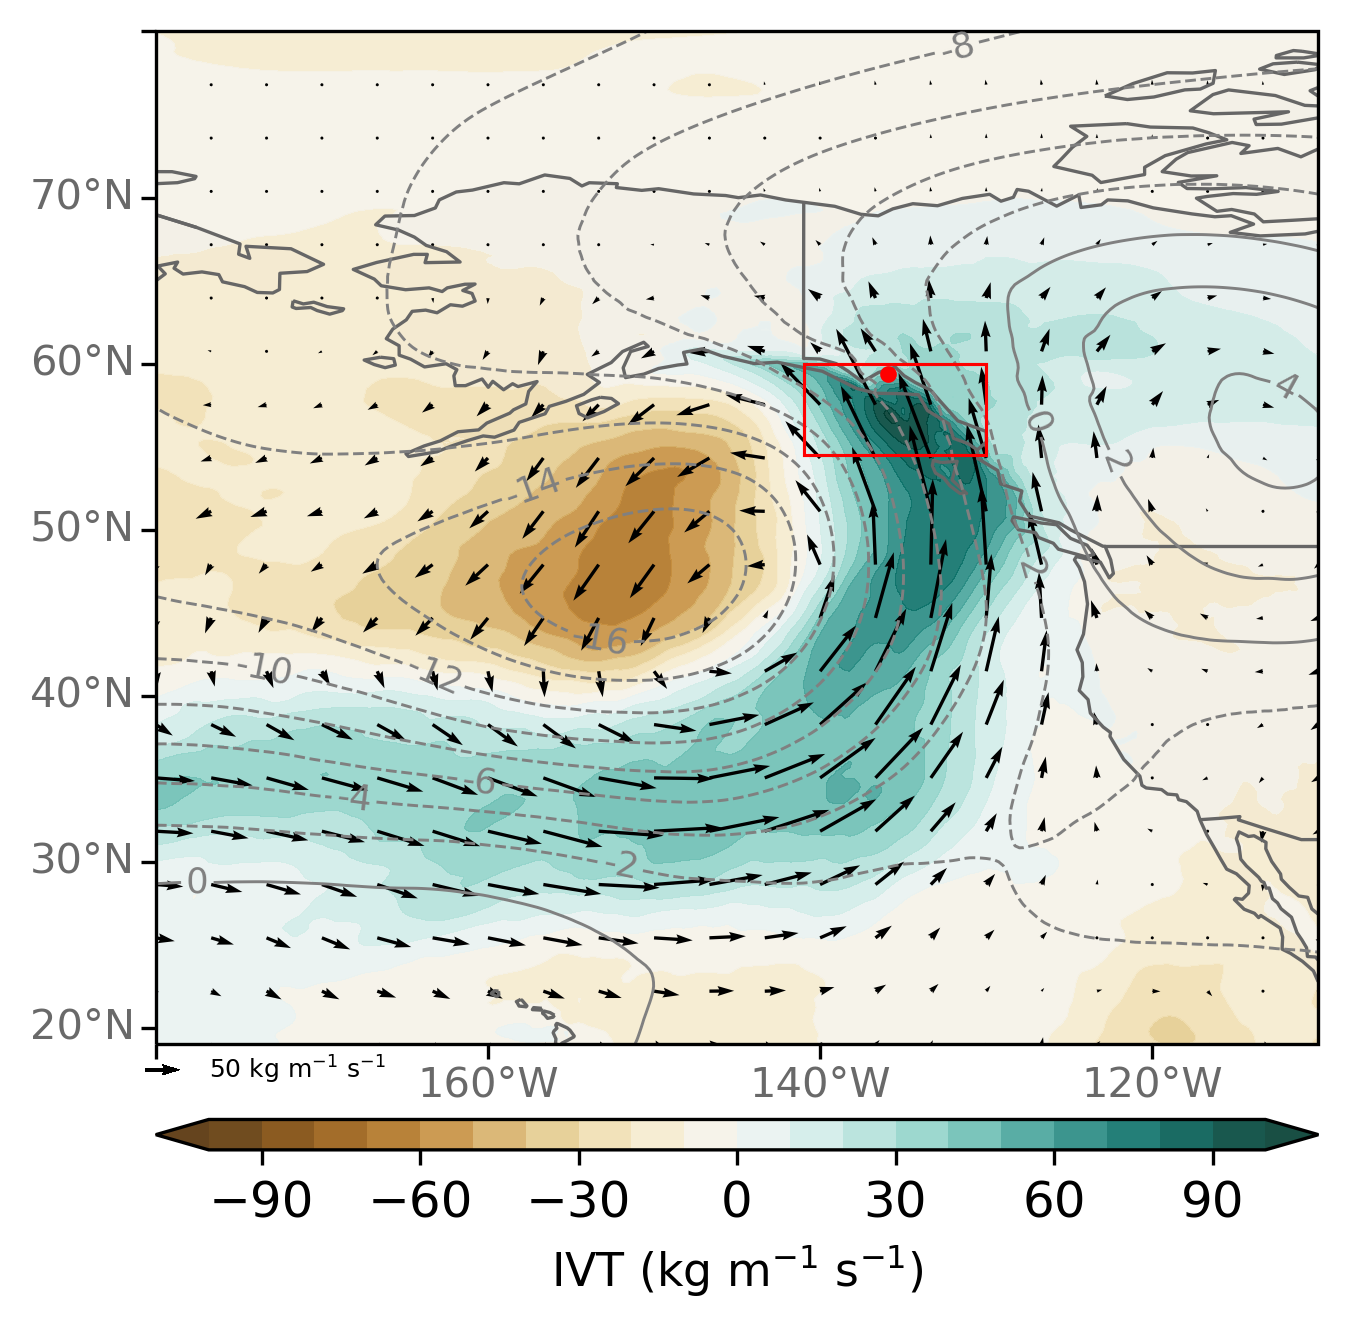

In [10]:
# Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_IVT-250Z_klukwan_poster'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

#########################
### KLUKWAN COMPOSITE ###
#########################

for k, ax in enumerate(axgr):
    
    ds = ds = ds_diff_final.sel(community=community_lst[2], lag=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(-100, 110, 10) # levels for IVT
    cmap = 'BrBG' # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec = ds.IVTu.values
    vvec = ds.IVTv.values
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=25, units='xy')

    # ax.set_title(community_lst[k], loc='left', fontsize=10)
    # titlestring = '({0})'.format(letter_lst[0])
    # ax.text(0.025, 0.9725, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)

    # Contour Lines
    hgts = ds.z.values/(10) # convert to dekameters # 250-hPa Heights
    clevs = np.arange(-20,22,2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)


    # quiver key
    qk = ax.quiverkey(Q, 0.02, -0.025, 50, '50 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 6.0})
    ext3 = [-141., -130., 54.5, 60.]
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
    
    # Plot Location of community pts
    ax.plot(xs[2], ys[2], 'ro', markersize=3, transform=datacrs)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()